In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
p2 = Paths("0518_p")

In [3]:
p4d = Pix4D(project_path=p2.pix4d_project, 
            raw_img_path=p2.raw_img, 
            project_name=p2.project_name,
            param_folder=p2.pix4d_param)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200518_P4M_10m_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200518_P4M_10m_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200518_P4M_10m_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [4]:
shp_file = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.shp"

In [5]:
process_area = shp.read_shp3d(shp_file, dsm_path=p4d.dsm_file, geotiff_proj=p4d.dsm_header['proj'], name_field="id", get_z_by="mean")
process_area.keys()

[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][shp][fields] Shp fields: {'id': 0, 'left': 1, 'top': 2, 'right': 3, 'bottom': 4}
[io][shp][proj] find ESRI projection file Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.prj, and successfully obtain projection cartesian


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [135]:
demo = process_area['1']
demo

array([[3.68058315e+05, 3.95605911e+06, 9.68296424e+01],
       [3.68060762e+05, 3.95605962e+06, 9.68296424e+01],
       [3.68061271e+05, 3.95605717e+06, 9.68296424e+01],
       [3.68058824e+05, 3.95605666e+06, 9.68296424e+01],
       [3.68058315e+05, 3.95605911e+06, 9.68296424e+01]])

In [136]:
img_dict = geo2raw.get_img_coords_dict(p4d, demo-p4d.offset.np, method="pmat")
img_dict.keys()

dict_keys(['DJI_0482.JPG', 'DJI_0483.JPG', 'DJI_0484.JPG', 'DJI_0485.JPG', 'DJI_0487.JPG', 'DJI_0488.JPG', 'DJI_0489.JPG', 'DJI_0546.JPG', 'DJI_0547.JPG', 'DJI_0548.JPG'])

In [137]:
img_dict["DJI_0482.JPG"]

array([[1017.88848378,  486.84575251],
       [2033.11427226,  600.33296177],
       [1923.76969068, 1614.11366838],
       [ 909.89186778, 1500.99420986],
       [1017.88848378,  486.84575251]])

In [81]:
# please refer to 01_slice/09_project2raw.ipynb
# calculate the distance
def calculate_dist2center(p4d, geo2raw_out_dict, id_name):
    dist_container = pd.DataFrame(columns=['id', 'image', 'xc', 'yc', 'dist', 'angle', #'direction', 
                                           "select", 'roi'])
    for i, c in geo2raw_out_dict.items():
        c = np.asarray(c)
        #x0, y0 = c.mean(axis=0)
        xmin, ymin = c.min(axis=0)
        xmax, ymax = c.max(axis=0)
        roi_w = xmax - xmin
        roi_h = ymax - ymin
        x0 = (xmax+xmin)/2
        y0 = (ymax+ymin)/2
                
        if roi_w > 1500 or roi_h > 1500:
            print(f"[Warning]: plot [{id_name}] on img [{i}], roi size ({roi_w},{roi_h}) exceed (1500, 1500)")
        

        x1, y1 = 0.5 * p4d.img[i].w, 0.5 * p4d.img[i].h
        d = np.sqrt((x1-x0) ** 2 + (y1 - y0) ** 2)
        
        v1 = np.asarray([x0-x1, y0-y1])
        v0 = np.asarray([0, 1])
        
        # https://blog.csdn.net/qq_32424059/article/details/100874358
        angle = calc_angle_2(v0, v1)
        """
        if angle > 45 and angle <= 135:
            direction = 'Right'
        elif angle > 135 and angle <= 225:
            direction = "Down"
        elif angle > 225 and angle <= 315:
            direction = "Left"
        else:
            direction = "Up"
        """
        
        dist_container.loc[len(dist_container)] = {"id":id_name, "image":i, "xc":x0, "yc":y0, "dist":d, 
                                                   "angle":angle, #"direction":direction,
                                                   "select":False, "roi":c}
        dist_container['dist'] = dist_container['dist'].astype(float)

    return dist_container

def calc_angle_2(v1, v2):
    '''
    支持大于180度计算
    https://www.pythonf.cn/read/131921
    '''
    r = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2)))
    deg = r * 180 / np.pi

    a1 = np.array([*v1, 0])
    a2 = np.array([*v2, 0])

    a3 = np.cross(a1, a2)

    if np.sign(a3[2]) > 0:
        deg = 360 - deg

    return deg

def select_best(dist_container, strategy="min_dist"):
    if strategy == "min_dist":
        dist_container = dist_container.sort_values(by=['dist'], axis=0, ascending=True)
        dist_container = dist_container.reset_index()
    
        return dist_container.iloc[0:10, :]
    else:
        dist_container = dist_container.sort_values(by=['direction', 'dist'], axis=0, ascending=True)
        
        direct = ['Up', 'Right', 'Down', 'Left']

        for i, d in enumerate(direct):
            t_all = reverse_dist[reverse_dist.direction == d]
            t = t_all.iloc[0,:]
            ax.scatter(t.xc, t.yc, c=color[i])

In [138]:
reverse_dist = calculate_dist2center(p4d, img_dict, id_name=1)
reverse_dist

,id,image,xc,yc,dist,angle,select,roi
0,1,DJI_0482.JPG,1471.503070,1050.479710,1482.324568,238.544967,False,"[[1017.8884837779842, 486.84575251241586], [20..."
1,1,DJI_0483.JPG,1367.806110,1861.314437,1368.702630,271.562227,False,"[[912.6226301208551, 1292.3382737349925], [193..."
2,1,DJI_0484.JPG,1267.481445,2695.976884,1707.890639,300.700992,False,"[[809.7740219922628, 2129.899271388765], [1834..."
3,1,DJI_0485.JPG,1192.032543,3046.014704,1969.049376,308.360804,False,"[[736.3315598987308, 2483.8644286071813], [175..."
4,1,DJI_0487.JPG,2476.126368,2312.642055,553.448608,331.994694,False,"[[2018.2962338366244, 1747.2769771778985], [30..."
5,1,DJI_0488.JPG,2542.564366,1512.101082,367.012642,211.806649,False,"[[2078.2774416322, 935.8175240343153], [3117.7..."
6,1,DJI_0489.JPG,2617.478679,671.912700,1158.167713,185.873657,False,"[[2148.2369835570444, 90.57006968902328], [319..."
7,1,DJI_0546.JPG,3929.815888,1361.501716,1280.273813,111.176952,False,"[[3475.192054995443, 784.2629106022234], [4501..."
8,1,DJI_0547.JPG,3845.974594,2173.227437,1163.616519,72.535042,False,"[[3386.9723541587473, 1599.9698288902139], [44..."
9,1,DJI_0548.JPG,3766.708259,2988.510917,1555.135104,41.512032,False,"[[3306.89136588437, 2420.3229135448337], [4343..."


In [139]:
reverse_dist.xc.idxmax()

7

In [140]:
reverse_dist.xc.idxmin()

3

In [141]:
y_temp = reverse_dist.copy().drop([reverse_dist.xc.idxmax(), reverse_dist.xc.idxmin()])
y_temp.xc.idxmax()

8

In [142]:
y_temp.xc.idxmin()

2

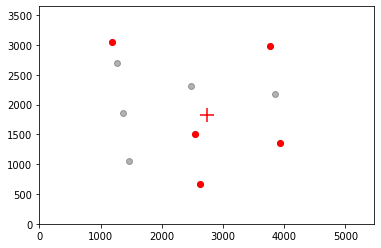

In [143]:
fig, ax = plt.subplots(1,1)

#max_idx = list(reverse_dist.groupby('direction').dist.idxmax())
xaxis = [reverse_dist.xc.idxmax(), reverse_dist.xc.idxmin()]
y_temp = reverse_dist.copy().drop(xaxis)
yaxis = [y_temp.yc.idxmax(), y_temp.yc.idxmin()]
min_idx = [reverse_dist.dist.idxmin()]
           
#reverse_dist.loc[min_idx+max_idx, 'select'] = True
reverse_dist.loc[min_idx+xaxis+yaxis, 'select'] = True

reverse_dist_sort = reverse_dist[reverse_dist.select]

ax.scatter(reverse_dist.xc, reverse_dist.yc, c='k', alpha=0.3)
ax.scatter(reverse_dist_sort.xc, reverse_dist_sort.yc, c='r')
ax.scatter(0.5 * p4d.img[0].w, 0.5 * p4d.img[0].h, marker="+", c='r', s=200)

ax.set_xlim([0, p4d.img[0].w])
ax.set_ylim([0, p4d.img[0].h])

plt.show()

In [144]:
reverse_dist

,id,image,xc,yc,dist,angle,select,roi
0,1,DJI_0482.JPG,1471.503070,1050.479710,1482.324568,238.544967,False,"[[1017.8884837779842, 486.84575251241586], [20..."
1,1,DJI_0483.JPG,1367.806110,1861.314437,1368.702630,271.562227,False,"[[912.6226301208551, 1292.3382737349925], [193..."
2,1,DJI_0484.JPG,1267.481445,2695.976884,1707.890639,300.700992,False,"[[809.7740219922628, 2129.899271388765], [1834..."
3,1,DJI_0485.JPG,1192.032543,3046.014704,1969.049376,308.360804,True,"[[736.3315598987308, 2483.8644286071813], [175..."
4,1,DJI_0487.JPG,2476.126368,2312.642055,553.448608,331.994694,False,"[[2018.2962338366244, 1747.2769771778985], [30..."
5,1,DJI_0488.JPG,2542.564366,1512.101082,367.012642,211.806649,True,"[[2078.2774416322, 935.8175240343153], [3117.7..."
6,1,DJI_0489.JPG,2617.478679,671.912700,1158.167713,185.873657,True,"[[2148.2369835570444, 90.57006968902328], [319..."
7,1,DJI_0546.JPG,3929.815888,1361.501716,1280.273813,111.176952,True,"[[3475.192054995443, 784.2629106022234], [4501..."
8,1,DJI_0547.JPG,3845.974594,2173.227437,1163.616519,72.535042,False,"[[3386.9723541587473, 1599.9698288902139], [44..."
9,1,DJI_0548.JPG,3766.708259,2988.510917,1555.135104,41.512032,True,"[[3306.89136588437, 2420.3229135448337], [4343..."


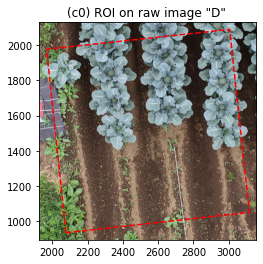

In [145]:
img_name = "DJI_0488.JPG"
img_coord = img_dict[img_name]

fig, ax = plt.subplots(1,1)

img_np = plt.imread(p4d.img[img_name].path)
img_coord = img_dict[img_name]
im_xmin, im_ymin = img_coord.min(axis=0)
im_xmax, im_ymax = img_coord.max(axis=0)

buffer=40

ax.imshow(img_np)
ax.plot(*img_coord.T, '--r')

ax.set_xlim(im_xmin-buffer, im_xmax+buffer)
ax.set_ylim(im_ymin-buffer, im_ymax+buffer)

ax.set_title(f'(c{0}) ROI on raw image "{img_name[0]}" ')

plt.show()

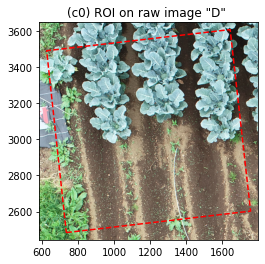

In [146]:
img_name = "DJI_0485.JPG"
img_coord = img_dict[img_name]

fig, ax = plt.subplots(1,1)

img_np = plt.imread(p4d.img[img_name].path)
img_coord = img_dict[img_name]
im_xmin, im_ymin = img_coord.min(axis=0)
im_xmax, im_ymax = img_coord.max(axis=0)

buffer=40

ax.imshow(img_np)
ax.plot(*img_coord.T, '--r')

ax.set_xlim(im_xmin-buffer, im_xmax+buffer)
ax.set_ylim(im_ymin-buffer, im_ymax+buffer)

ax.set_title(f'(c{0}) ROI on raw image "{img_name[0]}" ')

plt.show()

# batch get all 

In [155]:
result_container = pd.DataFrame(columns=['id', 'image', 'xc', 'yc', 'dist', 'angle', 
                                          "select", 'roi'])
for plot_id, roi in process_area.items():
    img_dict = geo2raw.get_img_coords_dict(p4d, roi-p4d.offset.np, method="pmat")
    
    reverse_dist = calculate_dist2center(p4d, img_dict, id_name=plot_id)
    
    xaxis = [reverse_dist.xc.idxmax(), reverse_dist.xc.idxmin()]
    y_temp = reverse_dist.copy().drop(xaxis)
    yaxis = [y_temp.yc.idxmax(), y_temp.yc.idxmin()]
    min_idx = [reverse_dist.dist.idxmin()]
    reverse_dist.loc[min_idx+xaxis+yaxis, 'select'] = True
    
    result_container = pd.concat([result_container, reverse_dist])

In [172]:
result_container['offset_x'] = round(result_container.xc - 750).astype(np.int32)
result_container['offset_y'] = round(result_container.yc - 750).astype(np.int32)

In [174]:
result_container

,id,image,xc,yc,dist,angle,select,roi,offset_x,offset_y
0,1,DJI_0482.JPG,1471.503070,1050.479710,1482.324568,238.544967,False,"[[1017.8884837779842, 486.84575251241586], [20...",722,300
1,1,DJI_0483.JPG,1367.806110,1861.314437,1368.702630,271.562227,False,"[[912.6226301208551, 1292.3382737349925], [193...",618,1111
2,1,DJI_0484.JPG,1267.481445,2695.976884,1707.890639,300.700992,False,"[[809.7740219922628, 2129.899271388765], [1834...",517,1946
3,1,DJI_0485.JPG,1192.032543,3046.014704,1969.049376,308.360804,True,"[[736.3315598987308, 2483.8644286071813], [175...",442,2296
4,1,DJI_0487.JPG,2476.126368,2312.642055,553.448608,331.994694,False,"[[2018.2962338366244, 1747.2769771778985], [30...",1726,1563
...,...,...,...,...,...,...,...,...,...,...
7,336,DJI_0127.JPG,3301.234760,1790.076662,566.251823,93.434565,False,"[[2872.2792345545718, 1254.4189204644658], [38...",2551,1040
8,336,DJI_0128.JPG,3368.364558,992.295775,1044.804696,142.753406,False,"[[2938.0171246308055, 455.483980033069], [3899...",2618,242
9,336,DJI_0136.JPG,4479.521140,1121.361260,1879.778488,111.949427,True,"[[4048.6963782235493, 580.5321694136546], [501...",3730,371
10,336,DJI_0137.JPG,4402.697996,1904.651399,1668.648213,87.229622,False,"[[3977.0720239931406, 1372.7123757100062], [49...",3653,1155


In [175]:
csv_folder = f"{p2.root}/13_roi_on_raw/{p2.project_name}"
if not os.path.exists(csv_folder):
    os.mkdir(csv_folder)

In [176]:
result_container.to_csv(f"{csv_folder}.csv", index=False)

In [183]:
result_container[result_container.offset_x < 0]

,id,image,xc,yc,dist,angle,select,roi,offset_x,offset_y
0,64,DJI_0360.JPG,636.850445,2068.951531,2113.393032,276.655792,True,"[[195.97574915660152, 1491.8702260868843], [12...",-113,1319
1,64,DJI_0361.JPG,737.415126,1288.771801,2069.012017,255.007784,False,"[[288.6664429373909, 703.4079698093387], [1320...",-13,539
0,65,DJI_0362.JPG,642.015185,1481.907066,2121.744561,260.721592,True,"[[173.84278737661043, 870.9338722387356], [125...",-108,732
0,66,DJI_0363.JPG,613.878383,1675.657542,2127.300083,266.001363,True,"[[142.33766293351619, 1063.2471443693917], [12...",-136,926
1,66,DJI_0364.JPG,732.225864,817.369568,2242.412900,243.326546,False,"[[261.62591403955184, 205.3853915271684], [134...",-18,67
...,...,...,...,...,...,...,...,...,...,...
0,320,DJI_0039.JPG,709.191481,3011.526718,2349.079071,300.366450,True,"[[295.0958182608506, 2489.628145388525], [1234...",-41,2262
0,330,DJI_0052.JPG,741.253853,2771.932138,2208.526098,295.417741,True,"[[328.24747370240993, 2235.3633251530255], [12...",-9,2022
0,331,DJI_0053.JPG,706.576713,2990.390825,2340.732029,299.887707,True,"[[291.20980833478006, 2454.523215052891], [124...",-43,2240
0,333,DJI_0056.JPG,733.417379,2607.302550,2150.325565,291.362763,True,"[[324.5959806177643, 2057.3961728715385], [128...",-17,1857


# save clip to folder

In [111]:
p4d.img["DJI_0485.JPG"].path

'Y:\\hwang_Pro\\data\\2020_tanashi_broccoli\\00_rgb_raw\\broccoli_tanashi_5_20200518_P4M_10m\\DJI_0485.JPG'

In [185]:
for idx, row in result_container[result_container.select].iterrows():
    print(row.image, row.id, end="\r")
    original = Image.open(p4d.img[row.image].path)
    cropped = original.crop([row.offset_x, row.offset_y, row.offset_x+1500, row.offset_y+1500])
    cropped.show()
    break

In [186]:
cropped.save("01_clip_raw_test.jpg")

In [187]:
for idx, row in result_container[result_container.select].iterrows():
    print(row.image, row.id, end='\r')
    original = Image.open(p4d.img[row.image].path)
    cropped = original.crop([row.offset_x, row.offset_y, row.offset_x+1500, row.offset_y+1500])
    
    cropped.save(f"{csv_folder}/{row.id}_{row.image}")

In [181]:
result_container[result_container.image=="DJI_0489.JPG"]

,id,image,xc,yc,dist,angle,select,roi,offset_x,offset_y
6,1,DJI_0489.JPG,2617.478679,671.912700,1158.167713,185.873657,True,"[[2148.2369835570444, 90.57006968902328], [319...",1867,-78
4,2,DJI_0489.JPG,2503.493712,1716.622267,256.103791,245.211222,True,"[[2021.4264614341153, 1122.8002954486071], [30...",1753,967
2,3,DJI_0489.JPG,2392.622136,2781.015694,1016.753361,340.261980,True,"[[1912.904012673873, 2196.762177312408], [2982...",1643,2031
7,22,DJI_0489.JPG,3663.328158,781.045038,1395.597566,138.358572,True,"[[3197.6218264174754, 199.20463352912066], [42...",2913,31
7,23,DJI_0489.JPG,3575.274103,1828.690541,839.287210,89.679788,False,"[[3098.5921268588754, 1236.1696525974126], [41...",2825,1079
6,24,DJI_0489.JPG,3458.058246,2894.639353,1291.370100,33.996428,True,"[[2983.9301960629837, 2311.9033636090153], [40...",2708,2145
11,43,DJI_0489.JPG,4682.521478,900.883242,2154.319014,115.372141,True,"[[4227.759505505426, 326.76803644943357], [524...",3933,151
10,44,DJI_0489.JPG,4618.679603,1937.434373,1886.093806,86.552009,False,"[[4155.890299744098, 1354.5720635850346], [519...",3869,1187
9,45,DJI_0489.JPG,4493.575180,2986.114100,2107.031014,56.527200,True,"[[4035.536071775017, 2414.5837116132075], [507...",3744,2236
